In [81]:
!pip install torch torchvision

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
from typing import List, Dict
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader

In [2]:
import re

def parse_trajectories(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    blocks = content.strip().split("\n\n")  # Split by blank lines (trajectories)
    all_trajectories = []

    for block in blocks:
        lines = block.strip().split("\n")
        trajectory = []

        for line in lines:
            actions = line.strip().split("-")
            timestep = []

            for action in actions:
                # Updated regex to support float durations
                match = re.match(r"r(\d+)\((\d+(?:\.\d+)?)\):p(\d+)\(([^)]+)\),p(\d+)\(([^)]+)\)", action.strip())
                if match:
                    r_id, duration_str, p_start, y_start_str, p_end, y_end_str = match.groups()

                    # Convert duration to float
                    duration = float(duration_str)
                    y_start = [int(label[1:]) for label in y_start_str.split(',')]
                    y_end = [int(label[1:]) for label in y_end_str.split(',')]

                    timestep.append({
                        "robot_id": int(r_id),
                        "duration": duration,
                        "p_start": int(p_start),
                        "y_start": y_start,
                        "p_end": int(p_end),
                        "y_end": y_end
                    })
                else:
                    print(f"Warning: Could not parse action: {action}")
            trajectory.append(timestep)

        all_trajectories.append(trajectory)

    return all_trajectories

# Parse the data from the log file
parsed_data = parse_trajectories("../Datasets/Office/Dataset1_noisy.txt")

# Print the parsed data for the first timestep in the first trajectory
print(parsed_data[0][0])  # first timestep in that trajectory

[{'robot_id': 1, 'duration': 5.88, 'p_start': 7, 'y_start': [1], 'p_end': 9, 'y_end': [5]}, {'robot_id': 3, 'duration': 6.82, 'p_start': 7, 'y_start': [1], 'p_end': 3, 'y_end': [4]}, {'robot_id': 4, 'duration': 7.12, 'p_start': 7, 'y_start': [1], 'p_end': 9, 'y_end': [5]}, {'robot_id': 2, 'duration': 6.04, 'p_start': 7, 'y_start': [1], 'p_end': 9, 'y_end': [5]}]


In [3]:
def find_long_trajectories(file_path, max_timesteps=10):
    """
    Reads a .txt file of trajectories and returns a list of indices of those
    trajectories that have more than `max_timesteps` timesteps.

    Parameters:
        file_path (str): Path to the trajectory file.
        max_timesteps (int): Threshold for maximum allowed timesteps.

    Returns:
        List[int]: Indices of long (spurious) trajectories.
    """
    with open(file_path, 'r') as f:
        content = f.read()

    blocks = content.strip().split("\n\n")
    long_traj_ids = []

    for i, block in enumerate(blocks):
        lines = block.strip().split("\n")
        if len(lines) > max_timesteps:
            long_traj_ids.append(i)

    return long_traj_ids


In [8]:
max_timesteps=25

file_path = "../Datasets/Office/Dataset1_noisy.txt"
long_ids_dataset = find_long_trajectories(file_path, max_timesteps)
print("Dataset too long trajectories: ", len(long_ids_dataset))

file_path_test = "../Datasets/Office/Testset1_noisy.txt"
long_ids_testset = find_long_trajectories(file_path_test, max_timesteps)
print("Testset too long trajectories: ", len(long_ids_testset))

Dataset too long trajectories:  44
Testset too long trajectories:  7


In [9]:
import torch
import torch.nn as nn

# Compute max ids from the parsed data
robot_ids = set()
place_ids = set()

for traj in parsed_data:
    for timestep in traj:
        for action in timestep:
            robot_ids.add(action['robot_id'])
            place_ids.add(action['p_start'])
            place_ids.add(action['p_end'])

max_robot_id = max(robot_ids) + 1
max_place_id = max(place_ids) + 1
max_timesteps = max(len(traj) for traj in parsed_data)

# Then initialize your embeddings
embed_dim = 32
robot_embedding_matrix = nn.Embedding(max_robot_id, embed_dim)
place_embedding_matrix = nn.Embedding(max_place_id, embed_dim)
timestep_embedding_matrix = nn.Embedding(max_timesteps, embed_dim)

# If you want to just use tensors here, extract their weight data:
robot_embeddings = robot_embedding_matrix.weight.data  # shape (max_robot_id, embed_dim)
place_embeddings = place_embedding_matrix.weight.data  # shape (max_place_id, embed_dim)

In [10]:
def sinusoidal_embedding(value, dim=32):
    """Sinusoidal embedding for a scalar value."""
    pe = torch.zeros(dim)
    position = torch.tensor(value, dtype=torch.float32)
    div_term = torch.exp(torch.arange(0, dim, 2).float() * -(np.log(10000.0) / dim))
    pe[0::2] = torch.sin(position * div_term)
    pe[1::2] = torch.cos(position * div_term)
    return pe

def time_embedding(duration, max_duration):
    """Sinusoidal encoding for duration using 2D angle."""
    normalized = np.log(duration + 1) / np.log(max_duration + 1)
    angle = 2 * np.pi * normalized
    return torch.tensor([np.sin(angle), np.cos(angle)], dtype=torch.float32)

def label_embedding(y_start, y_end, num_labels=5):
    """Label transition encoding: -1 for origin labels, 1 for destination labels, 0 otherwise."""
    vec = torch.zeros(num_labels)
    for i in y_start:
        vec[i - 1] = -1
    for i in y_end:
        if vec[i - 1] == -1:
            vec[i - 1] = 0  
        else:
            vec[i - 1] = 1
    return vec

def timestep_embedding(position, dim=32):
    """Sinusoidal positional encoding for timestep index."""
    pe = torch.zeros(dim)
    position = torch.tensor(position, dtype=torch.float32)
    div_term = torch.exp(torch.arange(0, dim, 2).float() * -(np.log(10000.0) / dim))
    pe[0::2] = torch.sin(position * div_term)
    pe[1::2] = torch.cos(position * div_term)
    return pe

In [11]:
def encode_actions(parsed_data, robot_embeddings, place_embeddings, timestep_embeddings, num_labels=5, embed_dim=32):
    max_duration = max(
        action['duration']
        for trajectory in parsed_data
        for timestep in trajectory
        for action in timestep
    )
    
    encoded_vectors = []

    for trajectory in parsed_data:
        encoded_trajectory = []

        for t_idx, timestep in enumerate(trajectory):
            timestep_vec = timestep_embeddings[t_idx]

            encoded_timestep = []

            for action in timestep:
                # Instead of sinusoidal, do lookup here:
                robot_vec = robot_embeddings[action['robot_id']]  
                p_start_vec = place_embeddings[action['p_start']]
                p_end_vec = place_embeddings[action['p_end']]

                label_vec = label_embedding(action['y_start'], action['y_end'], num_labels=num_labels)
                time_vec = time_embedding(action['duration'], max_duration)

                full_vec = torch.cat([
                    robot_vec,
                    p_start_vec,
                    p_end_vec,
                    label_vec,
                    time_vec,
                    timestep_vec
                ])

                encoded_timestep.append(full_vec)
            encoded_trajectory.append(encoded_timestep)

        encoded_vectors.append(encoded_trajectory)

    return encoded_vectors

In [12]:
# Parse the data from the log file
parsed_data = parse_trajectories("../Datasets/Office/Dataset1_noisy.txt")
test_data = parse_trajectories("../Datasets/Office/Testset1_noisy.txt")
# Set the number of labels manually
num_labels = 10  # Change this based on the number of labels you want

# Example: create embedding matrices (trainable parameters should be managed separately during training)
robot_embedding_matrix = nn.Embedding(max_robot_id, embed_dim)
place_embedding_matrix = nn.Embedding(max_place_id, embed_dim)

# Pass the weight tensors:
encoded_vectors = encode_actions(
    parsed_data,
    robot_embedding_matrix.weight.data,
    place_embedding_matrix.weight.data,
    timestep_embeddings=timestep_embedding_matrix.weight.data,
    num_labels=num_labels,
    embed_dim=embed_dim
)

test_vectors = encode_actions(
    test_data,
    robot_embedding_matrix.weight.data,
    place_embedding_matrix.weight.data,
    timestep_embeddings=timestep_embedding_matrix.weight.data,
    num_labels=num_labels,
    embed_dim=embed_dim
)

# Print the encoded vector for the first timestep in the first trajectory
print(encoded_vectors[0][0][0])  # First timestep in the first trajectory
print(f"Vector size: {encoded_vectors[0][0][0].shape}")  # Expected size


tensor([-0.2219,  1.5013,  0.6349,  1.3530, -0.1949, -0.4475, -0.3706,  1.1724,
        -0.7775,  0.9897, -0.0493, -0.6506,  0.8303, -0.4143,  2.2254, -1.1632,
        -1.9889,  0.3470, -0.8890,  0.3576,  0.5560,  0.4410,  0.9268,  1.2906,
        -0.9743, -0.7623,  0.0126,  0.9569, -1.5069, -0.7545,  0.7867, -0.8443,
         1.7918,  0.9991, -0.3208,  0.0533, -1.0663,  0.4325,  1.1255, -0.0629,
         1.8728, -0.7214, -0.6956, -2.1936,  0.8223,  2.2074, -0.5068, -0.5204,
        -1.0451, -0.4731, -0.1147, -1.1355, -1.5378,  1.8629,  0.1841, -0.8164,
        -1.0852, -0.2103, -0.6350, -1.8185, -1.9930, -0.9965,  1.6109, -0.2824,
        -0.3351, -1.9881, -0.5682,  0.9285, -1.3295, -1.3235,  2.7227,  0.4459,
        -0.4769,  0.3987,  1.3127, -0.4308, -1.6942, -0.8652, -0.6947,  0.1241,
        -0.0607, -0.6055, -1.1873,  0.8454,  0.6910, -0.2337, -0.4357,  0.2838,
        -1.7314,  0.2301,  0.2813, -0.1027,  0.2018,  0.4281,  1.9227,  1.6029,
        -1.0000,  0.0000,  0.0000,  0.00

In [13]:
#########################################   PREPARE DATA    #######################################################

In [14]:
def organize_trajectories_flat(encoded_vectors):
    """
    Convert each trajectory into a flat sequence of action vectors.
    Returns a list of tensors: each tensor is (num_actions, 137)
    """
    flat_trajectories = []

    for traj in encoded_vectors:
        actions = []
        for timestep in traj:
            actions.extend(timestep)  # Flatten timestep
        traj_tensor = torch.stack(actions)  # Shape: (num_actions, 137)
        flat_trajectories.append(traj_tensor)

    return flat_trajectories


In [15]:
flat_trajectories = organize_trajectories_flat(encoded_vectors)
test_trajectories = organize_trajectories_flat(test_vectors)
# Inspect
print(flat_trajectories[0].shape)  # Should be (num_actions_in_first_traj, feature_dim)


torch.Size([44, 140])


In [16]:
#####################################################  ARCHITECTURE  ##################################################

In [17]:
import torch
import torch.nn as nn

class TrajectoryClassifier(nn.Module):
    def __init__(self, input_dim=140, hidden_dim=256, num_heads=4, num_layers=2, use_cls_token=False, pooling='mean'):
        super(TrajectoryClassifier, self).__init__()
        self.use_cls_token = use_cls_token
        self.pooling = pooling

        self.input_proj = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        if use_cls_token:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))  # (1, 1, D)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, mask=None):
        """
        x: (batch_size, seq_len, input_dim)
        mask: optional attention mask (batch_size, seq_len)
        """
        B, L, _ = x.size()

        x = self.input_proj(x)  # (B, L, D)

        if self.use_cls_token:
            cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
            x = torch.cat([cls_token, x], dim=1)  # (B, L+1, D)

            if mask is not None:
                cls_mask = torch.ones(B, 1, dtype=mask.dtype, device=mask.device)
                mask = torch.cat([cls_mask, mask], dim=1)  # (B, L+1)

        x = self.transformer(x, src_key_padding_mask=(~mask) if mask is not None else None)

        if self.use_cls_token:
            output = x[:, 0, :]  # Take the CLS token
        else:
            if self.pooling == 'mean':
                output = x.mean(dim=1)
            elif self.pooling == 'max':
                output = x.max(dim=1).values
            elif self.pooling == 'sum':
                output = x.sum(dim=1)
            else:
                raise ValueError("Unsupported pooling type")

        return self.classifier(output)


In [18]:
from torch.utils.data import Dataset

class TrajectoryDataset(Dataset):
    def __init__(self, trajectories, labels):
        self.trajectories = trajectories
        self.labels = labels

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        x = self.trajectories[idx]  # Tensor of shape (seq_len, 137)
        y = torch.tensor([self.labels[idx]], dtype=torch.float32)  # shape (1,)
        return x, y

class UnlabeledTrajectoryDataset(Dataset):
    def __init__(self, trajectories):
        self.trajectories = trajectories

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        x = self.trajectories[idx]
        return torch.tensor(x, dtype=torch.float32), idx  # Return index to track



In [19]:
##############################################################################

In [20]:
#---------Dataset1------------------

#labels = [0]*1000 + [1]*100 + [0]*4000 + [1]*5100  # Total = 10200
#labels = [0]*1000 + [1]*100 + [0]*4000 + [1]*100 

#---------Dataset2------------------

#labels = [0]*1000 + [1]*1000

#----------------Dataset3 --------------------

labels = [0]*1000 + [1]*1000

#labels = [0]*1000 + [1]*500 + [0]*500

for idx in long_ids_dataset:
    if 0 <= idx < len(labels):  # safety check
        labels[idx] = 1


import random

# Pair trajectories with labels
data = list(zip(flat_trajectories, labels))

# Shuffle to randomize order
random.seed(42)
random.shuffle(data)


In [21]:
num_total = len(data)  
num_train = int(0.8 * num_total)       
num_val = int(0.1 * num_total)        


train_data = data[:num_train]
val_data   = data[num_train:num_train + num_val]


# Unzip
train_x, train_y = zip(*train_data)
val_x, val_y     = zip(*val_data)



In [22]:
train_dataset = TrajectoryDataset(train_x, train_y)
val_dataset   = TrajectoryDataset(val_x, val_y)


from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = UnlabeledTrajectoryDataset(test_trajectories)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [23]:
##############################################################################################

In [24]:
###############################################   Training   #############################################

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = TrajectoryClassifier(
    input_dim=140,
    hidden_dim=256,
    num_heads=4,
    num_layers=2,
    use_cls_token=False,
    pooling='max'
).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [26]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)  # (batch_size, 1)
        loss = criterion(output.view(-1), y.float().view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)



In [27]:
@torch.no_grad()
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output.view(-1), y.float().view(-1))
        total_loss += loss.item()

        preds = (output.view(-1) > 0.5).long()
        correct += (preds == y).sum().item()
        total += y.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy


In [28]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc: {val_acc:.4f}")


#test_loss, test_acc = evaluate(model, test_loader, criterion)
#print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Epoch 1/20
  Train Loss: 0.6624
  Val Loss:   0.6367 | Val Acc: 0.6600
Epoch 2/20
  Train Loss: 0.6518
  Val Loss:   0.6398 | Val Acc: 0.6600
Epoch 3/20
  Train Loss: 0.6512
  Val Loss:   0.6362 | Val Acc: 0.6600
Epoch 4/20
  Train Loss: 0.6454
  Val Loss:   0.6349 | Val Acc: 0.6600
Epoch 5/20
  Train Loss: 0.6396
  Val Loss:   0.6183 | Val Acc: 0.6667
Epoch 6/20
  Train Loss: 0.6304
  Val Loss:   0.6057 | Val Acc: 0.6533
Epoch 7/20
  Train Loss: 0.6104
  Val Loss:   0.6841 | Val Acc: 0.6600
Epoch 8/20
  Train Loss: 0.5944
  Val Loss:   0.5981 | Val Acc: 0.6933
Epoch 9/20
  Train Loss: 0.5601
  Val Loss:   0.5884 | Val Acc: 0.6867
Epoch 10/20
  Train Loss: 0.5094
  Val Loss:   0.5906 | Val Acc: 0.6533
Epoch 11/20
  Train Loss: 0.4808
  Val Loss:   0.6768 | Val Acc: 0.6867
Epoch 12/20
  Train Loss: 0.4251
  Val Loss:   0.7230 | Val Acc: 0.6667
Epoch 13/20
  Train Loss: 0.3595
  Val Loss:   0.7416 | Val Acc: 0.6400
Epoch 14/20
  Train Loss: 0.3293
  Val Loss:   0.8931 | Val Acc: 0.6533
E

In [29]:
##############################################  Test  ##############################################

In [30]:
def infer_unlabeled(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for idx, x in enumerate(dataloader):
            # x is a list or tuple with one tensor, shape (seq_len, input_dim)
            if isinstance(x, (list, tuple)):
                x = x[0]
            x = x.to(device)

            # Ensure shape is (1, seq_len, input_dim)
            if x.dim() == 2:
                x = x.unsqueeze(0)

            out = model(x)  # shape: [1, 1]
            score = out.item()
            label = 1 if score > 0.5 else 0
            predictions.append((idx, label, score))

    return predictions


In [31]:
#----------------Dataset1 --------------------

#test_true_labels = [1]*1000 + [0]*1000
#test_true_labels = [1]*1000 + [0]*1000 + [1]*250

#----------------Dataset2 --------------------

test_true_labels = [0]*150 + [1]*150
#test_true_labels = [0]*150 + [1]*75 + [0]*75

#----------------Dataset3 --------------------

#test_true_labels = [0]*100 + [1]*100


for idx in long_ids_testset:
    if 0 <= idx < len(test_true_labels):  # safety check
        test_true_labels[idx] = 1

predictions = infer_unlabeled(model, test_loader)
preds = [p[1] for p in predictions]

correct = sum(p == t for p, t in zip(preds, test_true_labels))
print(f"Accuracy: {correct / len(test_true_labels):.2%}")

print("Incorrectly classified trajectories:")
for idx, (pred, true) in enumerate(zip(preds, test_true_labels)):
    if pred != true:
        print(f"Trajectory {idx}: Predicted = {pred}, True = {true}")

C:\Users\salan\AppData\Local\Temp\ipykernel_29680\2081856653.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), idx  # Return index to track


Accuracy: 57.33%
Incorrectly classified trajectories:
Trajectory 0: Predicted = 1, True = 0
Trajectory 7: Predicted = 1, True = 0
Trajectory 10: Predicted = 1, True = 0
Trajectory 19: Predicted = 1, True = 0
Trajectory 22: Predicted = 1, True = 0
Trajectory 47: Predicted = 1, True = 0
Trajectory 50: Predicted = 1, True = 0
Trajectory 51: Predicted = 1, True = 0
Trajectory 54: Predicted = 1, True = 0
Trajectory 57: Predicted = 1, True = 0
Trajectory 76: Predicted = 1, True = 0
Trajectory 78: Predicted = 1, True = 0
Trajectory 79: Predicted = 1, True = 0
Trajectory 80: Predicted = 1, True = 0
Trajectory 83: Predicted = 1, True = 0
Trajectory 98: Predicted = 1, True = 0
Trajectory 99: Predicted = 1, True = 0
Trajectory 102: Predicted = 1, True = 0
Trajectory 112: Predicted = 1, True = 0
Trajectory 114: Predicted = 1, True = 0
Trajectory 119: Predicted = 1, True = 0
Trajectory 130: Predicted = 0, True = 1
Trajectory 145: Predicted = 1, True = 0
Trajectory 148: Predicted = 1, True = 0
Traje

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
acc = accuracy_score(test_true_labels, preds)
prec = precision_score(test_true_labels, preds)
rec = recall_score(test_true_labels, preds)
f1 = f1_score(test_true_labels, preds)
cm = confusion_matrix(test_true_labels, preds)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.5733
Precision: 0.6714
Recall:    0.3092
F1 Score:  0.4234


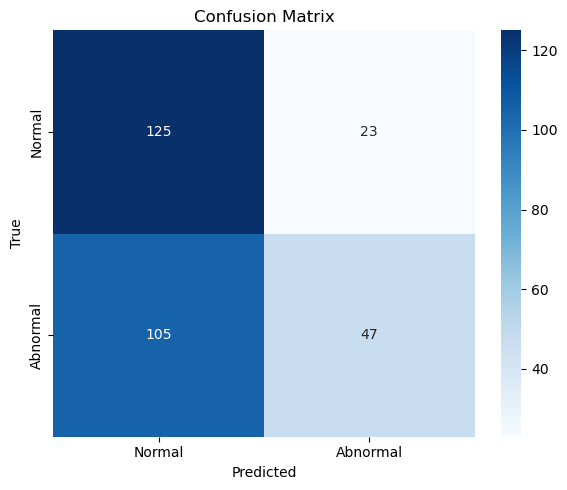

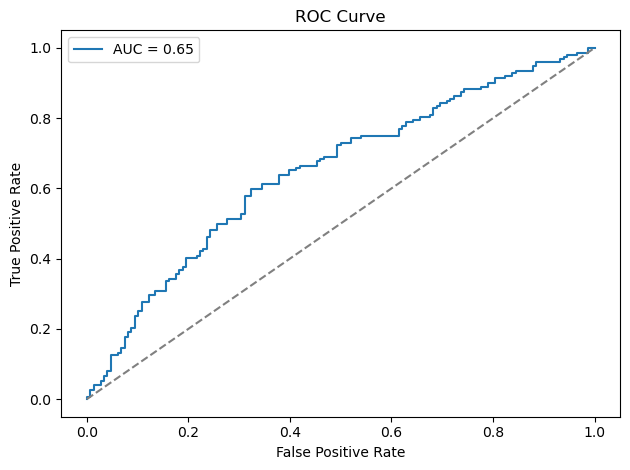

In [33]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# If you return raw probabilities from the model:
raw_scores = [p[2] for p in predictions]  # e.g., (index, label, score)
fpr, tpr, _ = roc_curve(test_true_labels, raw_scores)
auc_score = roc_auc_score(test_true_labels, raw_scores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\salan\AppData\Local\Temp\ipykernel_29680\2081856653.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), idx  # Return index to track


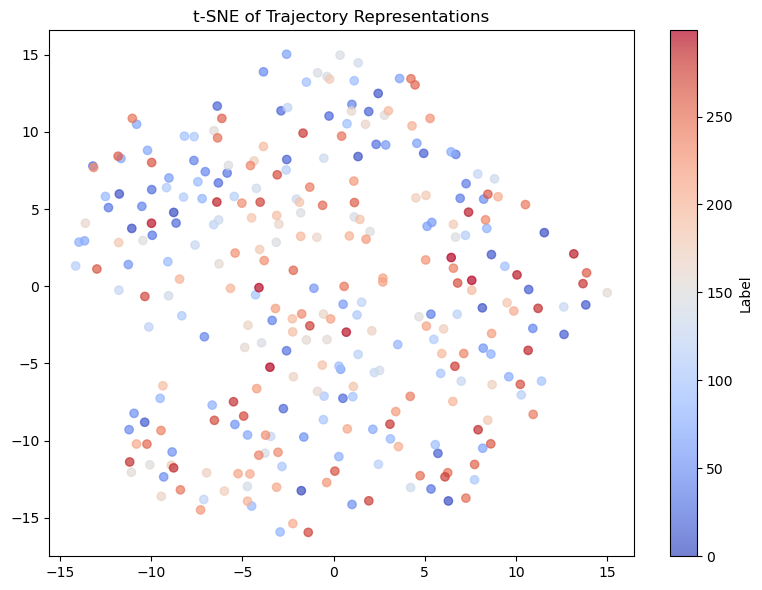

In [34]:
from sklearn.manifold import TSNE
import numpy as np

# Extract hidden states (vector per trajectory) from model
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            out = model.input_proj(x)
            out = model.transformer(out)
            if model.use_cls_token:
                rep = out[:, 0, :]  # CLS token
            else:
                rep = out.mean(dim=1)
            features.append(rep.cpu().squeeze().numpy())
            labels.append(y.item())
    return np.array(features), np.array(labels)

feat, lbls = extract_features(model, test_loader)

tsne = TSNE(n_components=2, random_state=42)
tsne_proj = tsne.fit_transform(feat)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=lbls, cmap="coolwarm", alpha=0.7)
plt.title("t-SNE of Trajectory Representations")
plt.colorbar(label="Label")
plt.tight_layout()
plt.show()


Trajectory 0: Predicted Label = 1, Score = 0.9388
Trajectory 1: Predicted Label = 0, Score = 0.0004
Trajectory 2: Predicted Label = 0, Score = 0.0079
Trajectory 3: Predicted Label = 0, Score = 0.2185
Trajectory 4: Predicted Label = 0, Score = 0.4294
Trajectory 5: Predicted Label = 0, Score = 0.0007
Trajectory 6: Predicted Label = 0, Score = 0.0014
Trajectory 7: Predicted Label = 1, Score = 0.5376
Trajectory 8: Predicted Label = 0, Score = 0.0001
Trajectory 9: Predicted Label = 0, Score = 0.1555
Trajectory 10: Predicted Label = 1, Score = 0.9802
Trajectory 11: Predicted Label = 0, Score = 0.0601
Trajectory 12: Predicted Label = 0, Score = 0.0032
Trajectory 13: Predicted Label = 0, Score = 0.0690
Trajectory 14: Predicted Label = 0, Score = 0.0128
Trajectory 15: Predicted Label = 0, Score = 0.1185
Trajectory 16: Predicted Label = 0, Score = 0.0044
Trajectory 17: Predicted Label = 0, Score = 0.0002
Trajectory 18: Predicted Label = 0, Score = 0.1763
Trajectory 19: Predicted Label = 1, Score

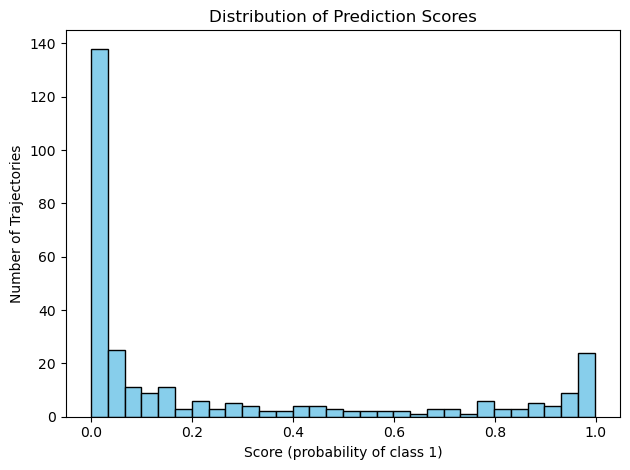

In [35]:
for idx, label, score in predictions:
    print(f"Trajectory {idx}: Predicted Label = {label}, Score = {score:.4f}")
import matplotlib.pyplot as plt

scores = [score for _, _, score in predictions]

plt.hist(scores, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Scores")
plt.xlabel("Score (probability of class 1)")
plt.ylabel("Number of Trajectories")
plt.tight_layout()
plt.show()
